In [1]:
%matplotlib inline

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os

In [58]:
import sys
sys.path.append('/Users/laurenaltman/Desktop/summer_research/machine_learning')

The most general object we can have is a **Particle**. It has a location in space (x,y,z), but that’s it. We have not yet defined what kind of particle it is, its shape, size, or its material properties. 

In [2]:
from pylorenzmie.theory import Particle
p = Particle()
print(p.r_p)
print(p.ab())

	No module named 'numba'
INFO:configuration: Falling back to standard implementation


[  0.   0. 100.]
[1.+0.j 1.+0.j]


When we run experiments, we are generally looking at colloidal spheres. Suppose we want to make a model of a **Sphere**. Sphere is a type of Particle, except now it has a size $a_p$, and a complex refractive index $n_p + i k_p$. This object also contains the computation for the Mie scattering coefficients for the sphere. 

In [3]:
from pylorenzmie.theory import Sphere
s = Sphere()
print(s.a_p)
print(s.n_p, s.k_p)
print(s.ab(n_m = 1.34, wavelength=0.447)[:4])

1.0
1.5 0.0
[[0.        +0.j         0.        +0.j        ]
 [0.5568827 +0.49675394j 0.6651625 +0.47193378j]
 [0.67591265+0.46803299j 0.56705786+0.49548296j]
 [0.59026502+0.49178486j 0.69229663+0.46154323j]]


Ok, so we have a spherical particle with some specified attributes. What does the resulting hologram look like? We can use **LMHologram**. LMHologram has a particle as its property, so once we create our LMHologram object, we can set its particle to be the Sphere we previously created. We must also specify the hologram’s **Instrument** properties. The hologram() method will produce the image from theory.

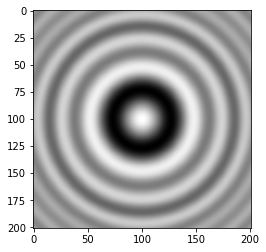

Instrument(wavelength=0.447, magnification=0.048, n_m=1.34, noise=0.05, darkcount=0.0)


In [4]:
from pylorenzmie.theory import LorenzMie
from pylorenzmie.utilities import coordinates
shape = [201, 201]
h = LorenzMie(coordinates=coordinates(shape))
s.r_p = [100,100,300]
h.particle = s
plt.imshow(h.hologram().reshape(shape), cmap='gray')
plt.show()
print(h.instrument)

So, we need to set the Instrument. The **Instrument** object has a magnification ($\mu m$ per pixel), a wavelength of the incident laser ($\mu m$), and the refractive index of the medium ($n_m$). Notice how much the hologram changes when we change the instrument!

Instrument(wavelength=0.447, magnification=0.048, n_m=1.34, noise=0.05, darkcount=0.0)


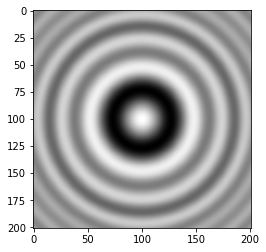

In [5]:
from pylorenzmie.theory import Instrument
#create an instrument object
ins = Instrument(wavelength = 0.447, magnification=0.048, n_m = 1.34)
print(ins)
#set the model's instrument
h.instrument = ins
plt.imshow(h.hologram().reshape(shape), cmap='gray')
plt.show()

Suppose you have some (normalized) experimental data that you want to compare to the theory. The **Feature** object is designed to do this. 

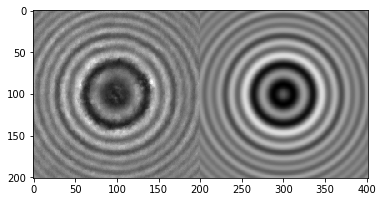

In [90]:
from pylorenzmie.theory import Feature
import cv2

f = Feature()
#experimental data
img = cv2.imread('test_image_crop_201.png')[:,:,0]
data = img.reshape(img.size)/100.
f.data = data
#our best guess
h.particle.a_p = 1.1
h.particle.n_p = 1.55
h.particle.z_p = 165
f.model = h

# Plot experimental image vs initial guesses 
guess = f.model.hologram().reshape(shape)
feature = f.data.reshape(shape)
plt.imshow(np.hstack([feature, guess]),
           cmap='gray')

Feature has a built-in method optimize() which will run a non-linear least-squares fit on the data, using the values from the hologram model as initial guesses.

In [76]:
from lmfit import report_fit
result = f.optimize()
report_fit(result)

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 55
    # data points      = 40401
    # variables        = 5
    chi-square         = 201540.532
    reduced chi-square = 4.98912100
    Akaike info crit   = 64939.9005
    Bayesian info crit = 64982.9336
[[Variables]]
    x_p:  99.0609548 +/- 0.00925634 (0.01%) (init = 99.39068)
    y_p:  100.354768 +/- 0.00896505 (0.01%) (init = 100.7742)
    z_p:  162.719479 +/- 0.05708994 (0.04%) (init = 165)
    a_p:  1.08601433 +/- 6.6465e-04 (0.06%) (init = 1.1)
    n_p:  1.54224372 +/- 1.7842e-04 (0.01%) (init = 1.55)
    k_p:  0 (fixed)
[[Correlations]] (unreported correlations are < 0.100)
    C(z_p, a_p) =  0.834
    C(a_p, n_p) = -0.664
    C(z_p, n_p) = -0.321


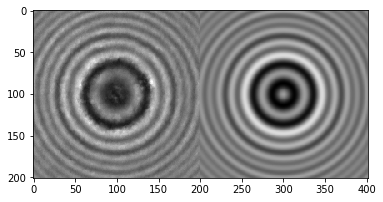

In [88]:
hfit = f.model
# Plot experimental data vs optimized hologram
guess = hfit.hologram().reshape(shape)
feature = f.data.reshape(shape)
plt.imshow(np.hstack([feature, guess]),
           cmap='gray')